In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#import warnings
#warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, LSTM, Embedding
from tensorflow.keras.utils import to_categorical

In [2]:
data = pd.read_csv('datasets/sequence_data.csv')
target = '600'
df = data[['short_name', 'sequence', target]]

In [3]:
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)
texts = list(df['words'])
for item in range(len(texts)):
    texts[item] = ' '.join(texts[item])

<ipython-input-3-2c0263da2d6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)


In [4]:
cv = CountVectorizer()
X = cv.fit_transform(texts).toarray()
y = df[target]
num_classes = 3
yc = pd.qcut(y, num_classes, labels=False)
yh = to_categorical(yc)

### Convolutional Filters

In [5]:
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [ ]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(132, 64, 1) (33, 64, 1) (132, 1) (33, 1)


In [116]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

In [117]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR
RF_model = RandomForestRegressor(n_estimators=100)
SVR_model = SVR()

X_for_RF = model.predict(X_train)
X_for_SVR = model.predict(X_train)

In [118]:
RF_model.fit(X_for_SVR, y_train.reshape(1, -1)[0])

RandomForestRegressor()

In [119]:
X_test_feature = model.predict(X_test)
prediction_RF = RF_model.predict(X_test_feature)

In [120]:
from sklearn.metrics import accuracy_score, r2_score
r2_score(y_test, prediction_RF)

0.2198804985142493

(0.0, 80000.0)

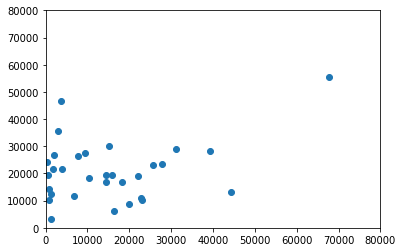

In [121]:
plt.scatter(y_test, prediction_RF)
plt.xlim([0, 80000])
plt.ylim([0, 80000])

In [ ]:
activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', input_shape = (SIZE, SIZE, 3)))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(32, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())

feature_extractor.add(Conv2D(64, 3, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
feature_extractor.add(BatchNormalization())
feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

### Classification

#### Multi-layer Perceptrons

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, yh, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

In [ ]:
history = model.fit(X_train, y_train, batch_size=100, epochs=10)

In [ ]:
_, acc = model.evaluate(X_test, y_test, verbose=1)
print("accuracy = " + str(acc))

#### CNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

#### RNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, yc, test_size=0.2, random_state=42)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
model = Sequential()
'''
top_words = 5000
max_review_length = 500
embedding_vecor_length = 32
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
'''
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
#model.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
#model.add(Dense(y_train.shape[1], activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
accuracy

### Regression

#### CNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
verbose, epochs, batch_size = 0, 5, 100
n_timesteps, n_features, n_outputs = X_train.shape[1], 1, y_train.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

In [ ]:
#plt.scatter(y_test, y_pred)
#plt.axhline(y=0, color='r', linestyle='-')
sns.regplot(y_test, y_pred)
plt.title('cNN')
#plt.xticks(rotation=90)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()

In [ ]:
ev = pd.DataFrame([y_test.ravel(), y_pred.ravel()]).T
ev.columns = ['test', 'pred']
ev[ev['pred']<15000].corr()

In [ ]:
sns.regplot(ev[ev['pred']<15000].test, ev[ev['pred']<15000].pred)

In [ ]:
y_pred[y_pred>15250]

In [ ]:
pd.DataFrame([y_test.ravel(), y_pred.ravel()]).T.corr()

#### RNN

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#reshape
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.values.reshape((y_train.shape[0], 1))
y_test = y_test.values.reshape((y_test.shape[0], 1))

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(n_timesteps, n_features)))
model.add(Dense(64, activation="relu"))
model.add(Dense(n_outputs))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=1)
y_pred = model.predict(X_test)

In [ ]:
sns.regplot(y_test, y_pred)
plt.title('RNN')
#plt.xticks(rotation=90)
plt.xlabel('Actual')
plt.ylabel('Prediction')
plt.show()